## Neural Network Modelling for NER using Self-Trained Word Embeddings with train-test split

#### Input Files:
#### Corpus_Sentences, Corpus_Sentences_Tags Corpus_POS_Tags, word_pos_vect_PubMed.csv
#### Output Files:
#### Corpus_Sentences_Test, Corpus_Sentences_Tags_Test, Corpus_POS_Tags_Test

In [1]:
import numpy as np
import pandas as pd
import csv

In [2]:
# Reading required Files
list_of_sent_tags = list()
list_of_sent_POS_tags = list()
list_of_sent_words = list()
with open("C:\\Project_NLP_Final\\Project Dataset\\PreProcessing\\Regex\\Corpus_Sentences.csv","r", encoding="utf8") as csv_file:
    csv_file = csv.reader(csv_file, delimiter=',', quotechar = '"')
    for row in csv_file:
        list_of_sent_words.append(row)

with open("C:\\Project_NLP_Final\\Project Dataset\\PreProcessing\\Regex\\Corpus_Sentences_Tags.csv","r", encoding="utf8") as csv_file:
    csv_file = csv.reader(csv_file, delimiter=',', quotechar = '"')
    for row in csv_file:
        list_of_sent_tags.append(row)
    
with open("C:\\Project_NLP_Final\\Project Dataset\\PreProcessing\\Regex\\Corpus_POS_Tags.csv","r", encoding="utf8") as csv_file:
    csv_file = csv.reader(csv_file, delimiter=',', quotechar = '"')
    for row in csv_file:
        list_of_sent_POS_tags.append(row)

In [3]:
list_of_sent_tags[0]

['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

In [4]:
list_of_sent_words[0]

['hospital', 'patient', 'name', ',', 'name', 'name', 'acct', '.']

In [5]:
list_of_sent_POS_tags[0]

['NNP', 'NNP', 'NNP', ',', 'NNP', 'NNP', 'NNP', '.']

In [6]:
req_list = [["Sentence: " + str(i + 1), word, POS, tag] for i, (sent, POS_sent, tag_sent) in enumerate(zip(list_of_sent_words, list_of_sent_POS_tags, list_of_sent_tags)) for word, POS, tag in zip(sent, POS_sent, tag_sent)]
data = pd.DataFrame(req_list, columns = ["Sentence #", "Word", "POS", "Tag"])
data.tail(20)

,Sentence #,Word,POS,Tag
730447,Sentence: 51972,signed,NNP,O
730448,Sentence: 51972,by,IN,O
730449,Sentence: 51972,name,NNP,O
730450,Sentence: 51972,name,NNP,O
730451,Sentence: 51972,name,NNP,O
730452,Sentence: 51972,",",",",O
730453,Sentence: 51972,md,NNP,O
730454,Sentence: 51972,date,NNP,O
730455,Sentence: 51972,14,CD,O
730456,Sentence: 51972,38,CD,O


In [17]:
words = list(set(data["Word"].values))
words = sorted(words)
words.append("endpad")
n_words = len(words); n_words

13455

In [18]:
tags = list(set(data["Tag"].values))
tags = sorted(tags)
n_tags = len(tags); n_tags

21

In [19]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [20]:
getter = SentenceGetter(data)

In [21]:
sent = getter.get_next()

In [22]:
print(sent)

[('hospital', 'NNP', 'O'), ('patient', 'NNP', 'O'), ('name', 'NNP', 'O'), (',', ',', 'O'), ('name', 'NNP', 'O'), ('name', 'NNP', 'O'), ('acct', 'NNP', 'O'), ('.', '.', 'O')]


In [23]:
sentences = getter.sentences

In [24]:
max_len = 75
word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [25]:
word2idx["vicodin"]

13090

In [26]:
tag2idx["B-Drug"]

2

In [27]:
# Converting all the data to keras readable format
from keras.preprocessing.sequence import pad_sequences
X = [[word2idx[w[0]] for w in s] for s in sentences]

Using TensorFlow backend.


In [28]:
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=n_words)

In [29]:
y = [[tag2idx[w[2]] for w in s] for s in sentences]

In [30]:
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])

In [31]:
from keras.utils import to_categorical

In [32]:
# Need to do this step for CRF
y = [to_categorical(i, num_classes=n_tags) for i in y]

In [33]:
from sklearn.model_selection import train_test_split

In [34]:
# Performing Train-Test split with test size of 0.2
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2)

In [35]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras_contrib.layers import CRF

In [40]:
# Neural Network Modelling
input = Input(shape=(max_len,))
model = Embedding(input_dim=n_words + 1, output_dim=100,
                  input_length=max_len, mask_zero=True)(input)  # 20-dim embedding
model = Bidirectional(LSTM(units=150, return_sequences=True,
                           recurrent_dropout=0.4))(model)  # variational biLSTM
model = TimeDistributed(Dense(50, activation="relu"))(model)  # a dense layer as suggested by neuralNer
crf = CRF(n_tags)  # CRF layer
out = crf(model)  # output

In [41]:
model = Model(input, out)

In [42]:
model.compile(optimizer="adam", loss=crf.loss_function, metrics=[crf.accuracy])

In [43]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 75)                0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 75, 100)           1345600   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 75, 300)           301200    
_________________________________________________________________
time_distributed_2 (TimeDist (None, 75, 50)            15050     
_________________________________________________________________
crf_2 (CRF)                  (None, 75, 21)            1554      
Total params: 1,663,404
Trainable params: 1,663,404
Non-trainable params: 0
_________________________________________________________________


In [44]:
from keras.callbacks import CSVLogger

csv_logger = CSVLogger("C:\\Project_NLP_Final\\Project Dataset\\Saved Models\\Word Embedding Train Test Split\\training_tt.log", separator=',', append=False)
history = model.fit(X_tr, np.array(y_tr), batch_size=31, epochs=20,
                    validation_split=0.2, verbose=1, callbacks=[csv_logger])

Train on 33261 samples, validate on 8316 samples
Epoch 1/8
33261/33261 [==============================] - 796s 24ms/step - loss: 0.1166 - acc: 0.9728 - val_loss: 0.0439 - val_acc: 0.9867
Epoch 2/8
33261/33261 [==============================] - 785s 24ms/step - loss: 0.0323 - acc: 0.9890 - val_loss: 0.0248 - val_acc: 0.9905
Epoch 3/8
33261/33261 [==============================] - 783s 24ms/step - loss: 0.0189 - acc: 0.9922 - val_loss: 0.0192 - val_acc: 0.9918
Epoch 4/8
33261/33261 [==============================] - 753s 23ms/step - loss: 0.0134 - acc: 0.9938 - val_loss: 0.0166 - val_acc: 0.9921
Epoch 5/8
33261/33261 [==============================] - 771s 23ms/step - loss: 0.0105 - acc: 0.9946 - val_loss: 0.0159 - val_acc: 0.9920
Epoch 6/8
33261/33261 [==============================] - 741s 22ms/step - loss: 0.0085 - acc: 0.9953 - val_loss: 0.0150 - val_acc: 0.9921
Epoch 7/8
33261/33261 [==============================] - 739s 22ms/step - loss: 0.0072 - acc: 0.9959 - val_loss: 0.0151 - v

In [45]:
import pandas as pd
# log_data = history.history
log_data = pd.read_csv("C:\\Project_NLP_Final\\Project Dataset\\Saved Models\\Word Embedding Train Test Split\\training_tt.log", sep=',', engine='python') 

In [46]:
from keras_contrib.utils import save_load_utils
save_load_utils.save_all_weights(model,"C:\\Project_NLP_Final\\Project Dataset\\Saved Models\\Word Embedding Train Test Split\\NN_model_tt.h5")
#model.save("C:\\Project_NLP_Final\\Project Dataset\\Saved Models\\Word Embedding Train Test Split\\NN_model_tt.h5")  # creates a HDF5 file 'my_model.h5'

In [59]:
from keras_contrib.utils import save_load_utils
# returns a compiled model
# identical to the previous one
#del model

save_load_utils.load_all_weights(model,"C:\\Project_NLP_Final\\Project Dataset\\Saved Models\\Word Embedding Train Test Split\\NN_model_tt.h5")
#model = load_model("C:\\Project_NLP_Final\\Project Dataset\\Saved Models\\Word Embedding Train Test Split\\NN_model_tt.h5", custom_objects={'CRF':CRF})

In [47]:
hist = pd.DataFrame(log_data)

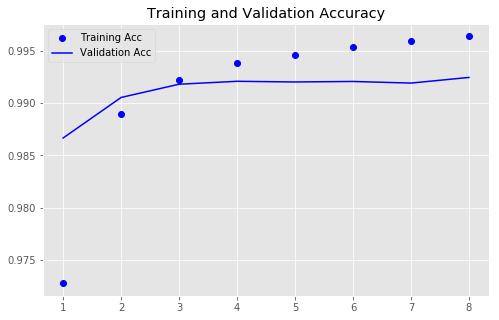

In [49]:
import matplotlib.pyplot as plt
acc = hist['acc']
val_acc = hist['val_acc']
epochs = range(1, len(acc) + 1)
plt.style.use("ggplot")
plt.figure(figsize=(8,5))
plt.plot(epochs, acc, 'bo', label='Training Acc')
plt.plot(epochs, val_acc, 'b', label='Validation Acc')
plt.title("Training and Validation Accuracy")
plt.legend()
plt.show()

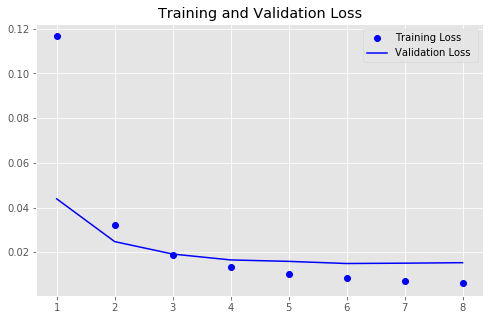

In [50]:
loss = hist['loss']
val_loss = hist['val_loss']
epochs = range(1, len(acc) + 1)
plt.style.use("ggplot")
plt.figure(figsize=(8,5))
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss ')
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

In [51]:
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report

In [60]:
# Predicting on the testing data
test_pred = model.predict(X_te, verbose=1)

10395/10395 [==============================] - 67s 6ms/step


In [61]:
idx2tag = {i: w for w, i in tag2idx.items()}

def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("PAD", "O"))
        out.append(out_i)
    return out
    
pred_labels = pred2label(test_pred)
test_labels = pred2label(y_te)
indices = [i for i, v in enumerate(pred_labels) if test_labels[i] != pred_labels[i]]

In [67]:
f1_score(test_labels, pred_labels, average='weighted')

In [68]:
f1_score(test_labels, pred_labels, average='micro')

In [69]:
f1_score(test_labels, pred_labels, average='macro')

In [70]:
print(classification_report(test_labels, pred_labels))

In [71]:
print("Number of Wrongly Classified sentences: ", len(indices))

In [44]:
import nltk

csv_pl = open("C:\\Project_NLP_Final\\Project Dataset\\Error Analysis\\Wrong Sentences.txt","w", encoding="utf8", newline='')

writer = csv.writer(csv_pl, delimiter=',', quotechar = '"')

for i in indices:
    sent = list()
    for w in X_te[i]:
        sent.append(words[w-1])
    pos_tag = [pos[1] for pos in nltk.pos_tag(sent)]
    p = model.predict(np.array([X_te[i]]))
    p = np.argmax(p, axis=-1)
    true = np.argmax(y_te[i], -1)
    writer.writerow([words[w-1] for w in X_te[i]])
    writer.writerow(pos_tag)
    writer.writerow([tags[t] for t in true])
    writer.writerow([tags[pred] for pred in p[0]])
    writer.writerow([])
csv_pl.close()

In [47]:
csv_pl = open("C:\\Project_NLP_Final\\Project Dataset\\Error Analysis\\System Predicted Less.txt","a", encoding="utf8", newline='')
csv_pm = open("C:\\Project_NLP_Final\\Project Dataset\\Error Analysis\\System Predicted More.txt","a", encoding="utf8", newline='')
csv_w = open("C:\\Project_NLP_Final\\Project Dataset\\Error Analysis\\System Predicted Wrongly But Identified NE.txt","a", encoding="utf8", newline='')
csv_ml = open("C:\\Project_NLP_Final\\Project Dataset\\Error Analysis\\System Predicted More and Less.txt","a", encoding="utf8", newline='')
csv_mw = open("C:\\Project_NLP_Final\\Project Dataset\\Error Analysis\\System Predicted More and Wrongly.txt","a", encoding="utf8", newline='')
csv_lw = open("C:\\Project_NLP_Final\\Project Dataset\\Error Analysis\\System Predicted Less and Wrongly.txt","a", encoding="utf8", newline='')
writer_pl = csv.writer(csv_pl, delimiter=',', quotechar = '"')
writer_pm = csv.writer(csv_pm, delimiter=',', quotechar = '"')
writer_w = csv.writer(csv_w, delimiter=',', quotechar = '"')
writer_ml = csv.writer(csv_ml, delimiter=',', quotechar = '"')
writer_mw = csv.writer(csv_mw, delimiter=',', quotechar = '"')
writer_lw = csv.writer(csv_lw, delimiter=',', quotechar = '"')
count = 0
for i in indices:
    p = model.predict(np.array([X_te[i]]))
    p = np.argmax(p, axis=-1)
    sent = list()
    for w in X_te[i]:
        sent.append(words[w-1])
    pos_tag = [pos[1] for pos in nltk.pos_tag(sent)]
    true = np.argmax(y_te[i], -1)
    flag = 0
    #print(flag, count)
    for w, t, pred in zip(X_te[i], true, p[0]):
        if t == pred:
            continue
        if(t != pred and t == tag2idx['O'] and pred != tag2idx['O'] and flag == 0):
            # Predicted More
            flag = 1
        if(t != pred and t != tag2idx['O'] and pred == tag2idx['O'] and flag == 0):
            # Predicted Less
            flag = 2
        if(t != pred and t != tag2idx['O'] and pred != tag2idx['O'] and flag == 0):
            # Predicted Wrongly
            flag = 3
        if(t != pred and ((t != tag2idx['O'] and pred == tag2idx['O'] and flag == 1) or (t == tag2idx['O'] and pred != tag2idx['O'] and flag == 2))):
            # More and Less
            flag = 4
        if(t != pred and ((t == tag2idx['O'] and pred != tag2idx['O'] and flag == 3) or (t != tag2idx['O'] and pred != tag2idx['O'] and flag == 1))):
            # More and Wrongly
            flag = 5
        if(t != pred and ((t != tag2idx['O'] and pred == tag2idx['O'] and flag == 3) or (t != tag2idx['O'] and pred != tag2idx['O'] and flag == 2))):
            # Less and Wrongly
            flag = 6
    if flag == 1:
        count += 1
        writer_pm.writerow([words[w-1] for w in X_te[i]])
        writer_pm.writerow(pos_tag)
        writer_pm.writerow([tags[t] for t in true])
        writer_pm.writerow([tags[pred] for pred in p[0]])
        writer_pm.writerow([])
    elif flag == 2:
        count += 1
        writer_pl.writerow([words[w-1] for w in X_te[i]])
        writer_pl.writerow(pos_tag)
        writer_pl.writerow([tags[t] for t in true])
        writer_pl.writerow([tags[pred] for pred in p[0]])
        writer_pl.writerow([])
    elif flag == 3:
        count += 1
        writer_w.writerow([words[w-1] for w in X_te[i]])
        writer_w.writerow(pos_tag)
        writer_w.writerow([tags[t] for t in true])
        writer_w.writerow([tags[pred] for pred in p[0]])
        writer_w.writerow([])
    elif flag == 4:
        count += 1
        writer_ml.writerow([words[w-1] for w in X_te[i]])
        writer_ml.writerow(pos_tag)
        writer_ml.writerow([tags[t] for t in true])
        writer_ml.writerow([tags[pred] for pred in p[0]])
        writer_ml.writerow([])
    elif flag == 5:
        count += 1
        writer_mw.writerow([words[w-1] for w in X_te[i]])
        writer_mw.writerow(pos_tag)
        writer_mw.writerow([tags[t] for t in true])
        writer_mw.writerow([tags[pred] for pred in p[0]])
        writer_mw.writerow([])
    elif flag == 6:
        count += 1
        writer_lw.writerow([words[w-1] for w in X_te[i]])
        writer_lw.writerow(pos_tag)
        writer_lw.writerow([tags[t] for t in true])
        writer_lw.writerow([tags[pred] for pred in p[0]])
        writer_lw.writerow([])

csv_pl.close()
csv_pm.close()
csv_w.close()
csv_ml.close()
csv_mw.close()
csv_lw.close()